In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from helpers.SimulationAnalysis import readHlist
from fast3tree import fast3tree

In [2]:
#load data
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
cases = ['c250-2048', 'c250-1024', 'c250-768', 'c250-512', 
         'c400-2048', 'c400-1024', 'c400-768', 'c125-2048-new', 'c125-1024']
nd_log_list = np.linspace(-3.3, -1.7, 17)

rbins = np.logspace(-1.3, 1.3, 27)

In [3]:
def point2JKindex(loc_array, box_size = 125., n = 10):
    dL = box_size/float(n)
    index = np.floor_divide(loc_array, dL).astype(int)
    return np.ravel_multi_index(index.T, (n,n,n))

def count_pairs_JKindex(points, rbins, box_size):
    pairs = [[] for r in rbins]
    with fast3tree(points) as tree:
        tree.set_boundaries(0, box_size)
        for pidx, p in enumerate(points):
            pJKidx = point2JKindex(p, box_size = box_size)
            for i, r in enumerate(rbins):
                idx, pos = tree.query_radius(p,r, periodic=True, output='both')
                pos = pos[idx < pidx]
                pairs[i].extend([pJKidx, j] for j in point2JKindex(pos, box_size = box_size))
    pairs = np.array([np.array(i) for i in pairs])
    
def JKindex2JKbox(idx, box_size = 125., n = 10):
    i,j,k = np.unravel_index(idx, (n,n,n))
    dL = float(box_size)/n
    return dL*np.array([[i, i+1],[j, j+1], [k, k+1]])

def JKindex2boxcenter(idx, box_size = 125., n = 10):
    i,j,k = np.unravel_index(idx, (n,n,n))
    dL = float(box_size)/n
    return dL*np.array([i+0.5, j+0.5, k+0.5])

def JK_std(data, axis = 0):
    return np.sqrt(data.shape[axis] - 1)*np.std(data, axis = 0)
    

## From smaller box counts to large JK box

In [4]:
_neighborbool = {}
def get_idx2JKidx_neighborbool(n, nJK):
    key = (n,nJK)
    if key in _neighborbool:
        return _neighborbool[key]
    box_size = 1.
    idx2JKidx = np.array([point2JKindex(JKindex2boxcenter(i, box_size,n), box_size, nJK) for i in range(n**3)])
    neighborbool = np.zeros((n**3, 27))
    xx, yy, zz = [grid.flatten() for grid in np.meshgrid([-1.,0,1.],[-1.,0,1.],[-1.,0,1.],indexing='ij')]
    dx, dy, dz = box_size/n*np.identity(3)
    shifts = np.outer(xx, dx) + np.outer(yy, dy) + np.outer(zz,dz)
    for i in range(n**3):
        center = JKindex2boxcenter(i, box_size, n)
        for j in range(27):
            neighborbool[i,j] = point2JKindex(np.mod(center + shifts[j], box_size), box_size, nJK) != idx2JKidx[i]
    _neighborbool[key] = (idx2JKidx, neighborbool)
    return _neighborbool[key]

_load_JK = {}
def boundaries2JK(proxy, case, nd, nJK, n = 12):
    key = (proxy, case, nd, nJK)
    if key in _load_JK:
        return _load_JK[key]
    JKcrosspairs = np.load('../ki22/resolution_study/pairs_{}/boundaries/{}_nd{:.1f}_nsave12.npy'.format(*key))
    JKcounts_cum = np.zeros((nJK**3, len(rbins)))
    idx2JKidx, neighborbool = get_idx2JKidx_neighborbool(n, nJK)

    for idx, nbool in enumerate(neighborbool):
        for j, b in enumerate(nbool):
            if b:
                JKcounts_cum[idx2JKidx[idx]] += JKcrosspairs[idx,:,j]
            else:
                JKcounts_cum[idx2JKidx[idx]] += 0.5*JKcrosspairs[idx,:,j]
    totalcounts = np.ediff1d(0.5*np.sum(JKcrosspairs, axis = (0,-1))[::2])
    JKcounts = np.array([totalcounts - np.ediff1d(i[::2]) for i in JKcounts_cum])
    _load_JK[key] = JKcounts
    return _load_JK[key]

_pairs_cache = {}
def load_pair_count(proxy, case, nd_log, cumulative=False, fixed_limits=False):
    key = (proxy, case, nd_log, 'f' if fixed_limits else 'c')
    if key not in _pairs_cache:
        _pairs_cache[key] = np.load('/nfs/slac/g/ki/ki06/yymao/resolution_test/pairs_{}/{}_nd{:.1f}_{}.npy'.format(*key)).astype(float)      
    return _pairs_cache[key] if cumulative else np.ediff1d(_pairs_cache[key][::2])


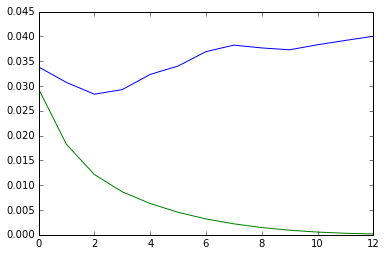

In [5]:
JKcounts = boundaries2JK('mvir', 'c400-768', -2.2, 3)
totalcounts = load_pair_count('mvir','c400-768', -2.2)
plt.plot(JK_std(JKcounts, axis = 0)/ totalcounts)
plt.plot( 1./np.sqrt(totalcounts))

## plot multi subplots

In [6]:
from AbundanceMatching import AbundanceFunction
from urllib import urlopen

x, phi_log = np.loadtxt(urlopen('http://arxiv.org/src/1304.7778v2/anc/LF_SerExp.dat'), usecols=(0,1)).T
af = AbundanceFunction(x, (10.**phi_log)*0.4/(0.7**3), ext_range=(-30.0, -5.0))

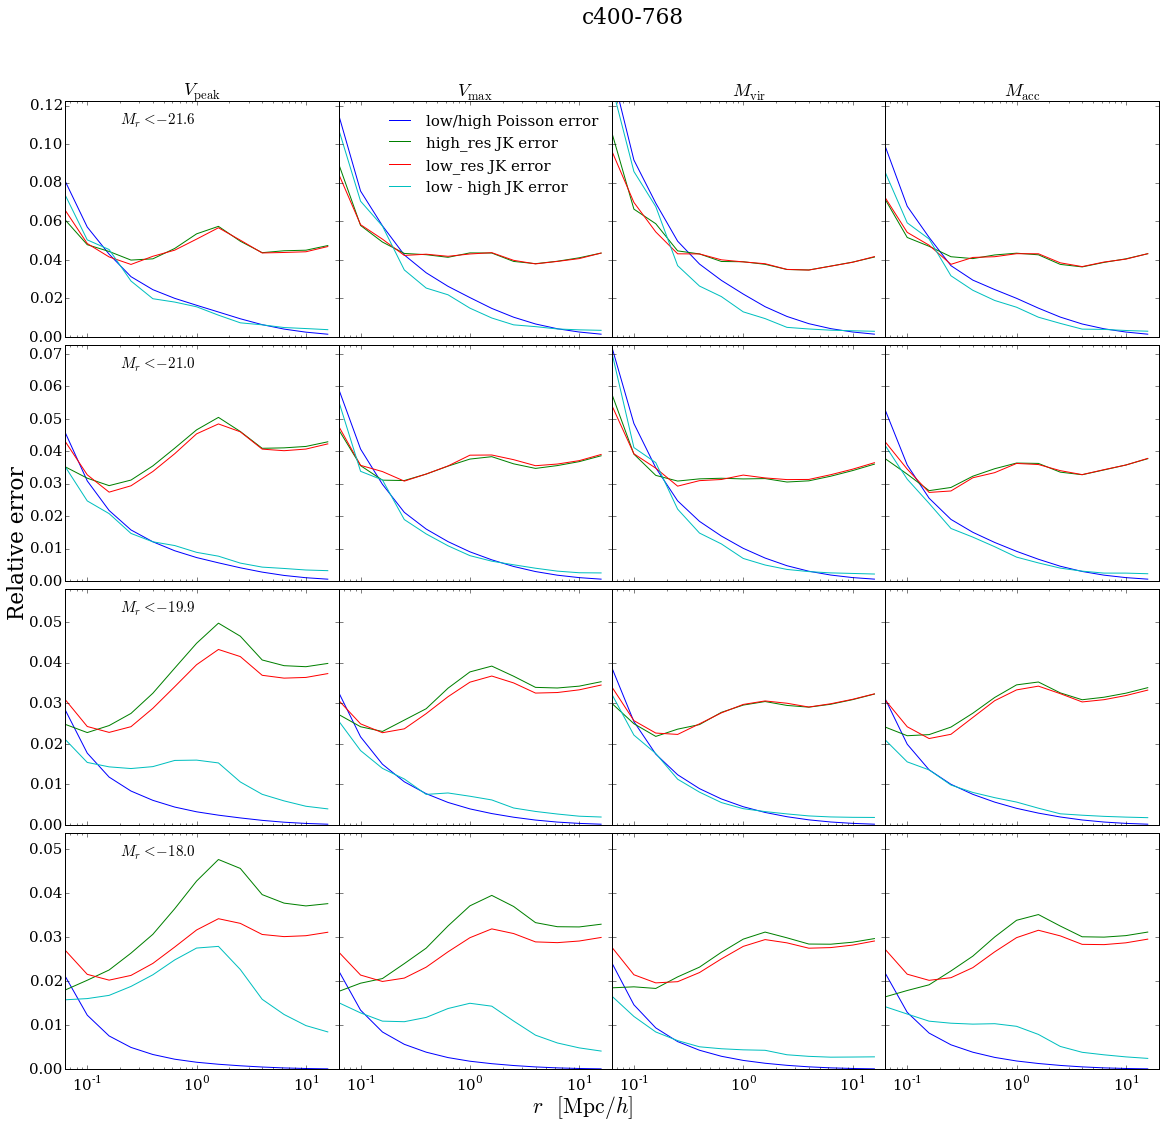

In [7]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.family'] = 'serif'
rbins = np.logspace(-1.3, 1.3, 27)
nd_log_list_this = (-3.0, -2.6,-2.2, -1.8)
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
#proxies = ['vpeak', 'mvir', 'macc']
case = 'c400-768'
nJK = 6

fig, ax = plt.subplots(ncols=len(proxies), nrows=len(nd_log_list_this), figsize=(16, 4*len(nd_log_list_this)), sharex=True, sharey= 'row')
for i, (ax_row, nd_log) in enumerate(zip(ax, nd_log_list_this)):
    for j, (ax_this, proxy_this) in enumerate(zip(ax_row, proxies)):
        lowJK = boundaries2JK(proxy_this, case, nd_log, nJK)
        highJK = boundaries2JK(proxy_this, case.split('-')[0] + '-2048', nd_log, nJK)
        totallow = load_pair_count(proxy_this, case, nd_log)
        totalhigh = load_pair_count(proxy_this, case.split('-')[0] + '-2048', nd_log)
        ax_this.semilogx(rbins[1::2], np.sqrt(1/totalhigh + 1/totallow), label = 'low/high Poisson error')
        ax_this.semilogx(rbins[1::2], (JK_std(highJK, axis = 0)/ np.mean(highJK, axis = 0)), label ='high_res JK error')
        ax_this.semilogx(rbins[1::2], (JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0)), label ='low_res JK error')
        #ax_this.semilogx(rbins[1::2], JK_std((lowJK-highJK) / highJK, axis = 0), label ='low/high JK error')
        ax_this.semilogx(rbins[1::2], (JK_std((lowJK-highJK) / np.mean(highJK, axis = 0), axis = 0)), label ='low - high JK error')
        if not i: ax_this.set_title(r'${0}_{{\rm {1}}}$'.format(proxy_this[0].upper(), proxy_this[1:]));
        if not j: ax_this.text(0.2, 0.96, '$M_r < {:.1f}$'.format(af.match(10.0**nd_log)), transform=ax_this.transAxes, va='top');
        if (i,j) == (0,1): ax_this.legend(loc='upper right', frameon=False, ncol=1, fontsize='medium');


        #plot settings
        ax_this.set_xlim(rbins[1], rbins[-1]);
        ax_this.set_ylim(0.0, 1.7 * max(JK_std(lowJK, axis = 0)/ np.mean(lowJK, axis = 0)));
        #ax_this.minorticks_on();

plt.tight_layout(0, rect=(0.02, 0.02, 1.0, 0.90));
fig.text(0.5, 0.95, case, fontsize='x-large')
fig.text(0.01, 0.5, 'Relative error', ha='center', va='center', rotation='vertical', fontsize='x-large');
fig.text(0.5, 0.01, r'$r \; [{\rm Mpc}/h]$', ha='center', va='center', fontsize='x-large');
fig.savefig('plots/c400_allproxy_nJK={:d}.png'.format(nJK))

# testing

The code for doing the following calculation is in '../ki22/resolution_study/hlist2boundaries_counts.py'

In [ ]:
case = 'c125-2048'
proxy = 'mvir'
n = 10
box_size = float(case[1:4])
hlist_path ='/u/ki/yymao/ki21/sham_test/resolution-test/{}/hlist_1.00000.npy'.format(case)
halos = np.load(hlist_path)
s = halos[proxy].argsort()

k = (10.0**nd_log_list * (box_size**3)).astype(int)
k *= -1

j, nd_log = zip(k, nd_log_list)[-1]

halos = halos[list('xyz')].view((float, 3))
halos = halos[s[j:]]

rbins = np.logspace(-1.3, 1.3, 27)

JKrange = 3

#JKautopairs = np.zeros((JKrange, len(rbins)))
JKcrosspairs = np.zeros((JKrange, len(rbins), 27))

n = 5
for JKidx in range(JKrange):
    # select the points inside the JK box
    xr, yr, zr = JKindex2JKbox(JKidx, box_size, n)
    xbool = (xr[0] - halos[:,0])*(xr[1] - halos[:,0]) < 0
    ybool = (yr[0] - halos[:,1])*(yr[1] - halos[:,1]) < 0
    zbool = (zr[0] - halos[:,2])*(zr[1] - halos[:,2]) < 0
    halos_JK = halos[np.all([xbool, ybool, zbool],axis=0)]
    #determine the neighboring 6 JK indices
    center = np.mean([xr, yr, zr], axis=-1)
    xx, yy, zz = [grid.flatten() for grid in np.meshgrid([-1.,0,1.],[-1.,0,1.],[-1.,0,1.],indexing='ij')]
    dx, dy, dz = float(box_size)/n*np.identity(3)
    shifts = np.outer(xx, dx) + np.outer(yy, dy) + np.outer(zz,dz)
    neighbor_JKindex = point2JKindex(np.mod(center + shifts , box_size), box_size, n)
    
    # calculate the number of autopairs and crosspairs(for crosspairs, also save which boundary they cross)
    # start with negative so that we don't count the halo pairing with itself
    #autopairs = -len(halos_JK)*np.ones_like(rbins)
    crosspairslist = np.zeros((len(rbins), 27))
    crosspairslist[:,13] = -len(halos_JK)*np.ones_like(rbins)
    with fast3tree(halos) as tree:
        for p in halos_JK:
            for i, r in enumerate(rbins):
                pos = tree.query_radius(p,r, periodic=True, output='pos')
                JKpos = point2JKindex(pos, box_size, n)
                #autopairs[i] += np.count_nonzero(JKpos == JKidx)
                for k, neighborJK in enumerate(neighbor_JKindex):
                    crosspairslist[i,k] += np.count_nonzero(JKpos == neighborJK)
    #JKautopairs[JKidx] = autopairs
    JKcrosspairs[JKidx] = crosspairslist
            
            
